In [39]:
include("../code/bp_full_gfq.jl")

gftables (generic function with 7 methods)

In [2]:
# Build a random graph with variables of degree exactly 2
# Inputs: size, rate

include("../code/ldpc_graph.jl")
function cycle_code(Q::Int, n::Int, R::Real; rng=MersenneTwister(0), T::Type=Int)
    @assert 0≤R≤1
    m = round(Int, n*(1-R))
    nedges, Lambda, Rho = generate_polyn(n,m,degree_type=:nodes)
    nedges = 2n
    H = permutedims(ldpc_matrix_gfq(Q,n,m,nedges,Lambda,Rho, accept_multi_edges=false,rng=rng,T=T))
end

cycle_code (generic function with 1 method)

In [3]:
function iteration_saveall!(bp::BPFull{F,SVector{Q,T}}; maxiter=10^3, tol=1e-12, 
        damp=0.0, rein=0.0, 
        update_f! = update_factor_bp!, update_v! = update_var_bp!,
        factor_neigs = [nonzeros(bp.X)[nzrange(bp.X, a)] for a = 1:size(bp.H,1)],
        gftab = gftables(Val(getQ(bp))), uaux=zero(MVector{Q,T}),
        parities=zeros(Int, maxiter), dist=zeros(maxiter), s=argmax.(bp.efield),
        callback=(it, ε, bp)->false) where {F,Q,T}

    Ht = permutedims(bp.H)

    ε = 0.0
    for it = 1:maxiter
        ε = 0.0
        for i = 1:size(bp.H,2)
            errv = update_v!(bp, i, damp=damp, rein=rein)
            errv == -1 && return -1,it
            ε = max(ε, errv)
        end
        for a = 1:size(bp.H,1)
            errf = update_f!(bp, a, gftab..., factor_neigs[a], uaux=uaux, damp=damp)
            errf == -1 && return -1,it
            ε = max(ε, errf)
        end
        x = argmax.(bp.belief)
        parities[it] = parity(bp, x, Ht)
        dist[it] = distortion(x,s,getQ(bp))
        callback(it, ε, bp) && return ε,it
        ε < tol && return ε, it
    end
    ε, maxiter
end

# alias for calling `iteration_saveall!` with maxsum updates
function iteration_ms_saveall!(ms::BPFull{F,SVector{Q,T}}; update_f! = update_factor_ms_quick!,
        update_v! = update_var_ms_quick!, kw...) where {F,Q,T}
    iteration_saveall!(ms; update_f! = update_f!, update_v! = update_v!, kw...)
end

iteration_ms_saveall! (generic function with 1 method)

## MS

In [42]:
include("../code/bp_full_gfq.jl")

gftables (generic function with 7 methods)

In [54]:
Q = 4
n = 300
R = 0.8
A = cycle_code(Q, n, R; rng=MersenneTwister(3))
s = rand(1:Q, n);

In [55]:
maxiter = 5*10^3
rein = 5/maxiter
ms = ms_full_gfq(A, Q, s)
ms_slow = deepcopy(ms)
ms_quick = deepcopy(ms);

In [56]:
iteration_ms!(ms_slow, maxiter=maxiter, rein=rein)

(2239.6477884824853, 5000)

In [57]:
performance(ms_slow, s)

(4, 0.041666666666666664)

In [58]:
iteration_ms_quick!(ms_quick, maxiter=maxiter, rein=rein)

(2894.3638801106717, 5000)

In [59]:
performance(ms_quick, s)

(1, 0.04)

In [60]:
using BenchmarkTools
@btime iteration_ms!($(deepcopy(ms)), maxiter=$maxiter, rein=$rein);

  1.516 s (2230943 allocations: 152.70 MiB)


In [ ]:
@btime iteration_ms_quick!($(deepcopy(ms)), maxiter=$maxiter, rein=$rein);

In [253]:
parities=zeros(Int, maxiter)
dist=zeros(maxiter)
ms = ms_full_gfq(A, Q, s)
iteration_ms_saveall!(ms, maxiter=maxiter, rein=rein, parities=parities, dist=dist, s=s,
    update_f! = update_factor_ms!, update_v! = update_var_ms_quick!)

(4.468571067502899e8, 5000)

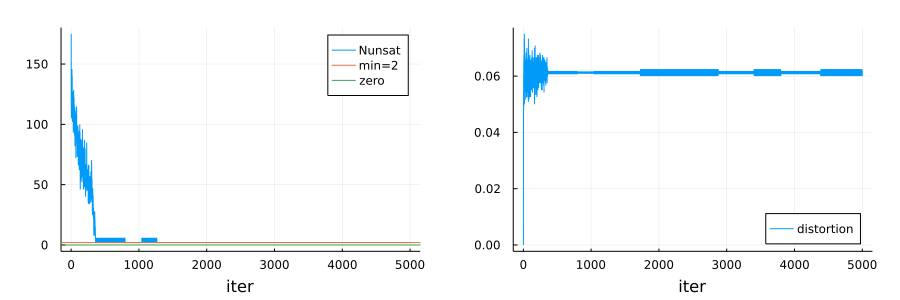

In [254]:
p1 = plot(parities, xlabel="iter", label="Nunsat")
minp = minimum(parities)
hline!(p1, [minp], label="min=$(Int(minp))")
hline!(p1, [0], label="zero")
p2 = plot(dist, xlabel="iter", label="distortion", legend=:bottomright)
plot(p1,p2, size=(900,300), margin=5Plots.mm)

In [184]:
nunsat,d = performance(ms, s)

(21, 0.17)

In [187]:
i = argmin(parities)
d = dist[i]

0.16583333333333333

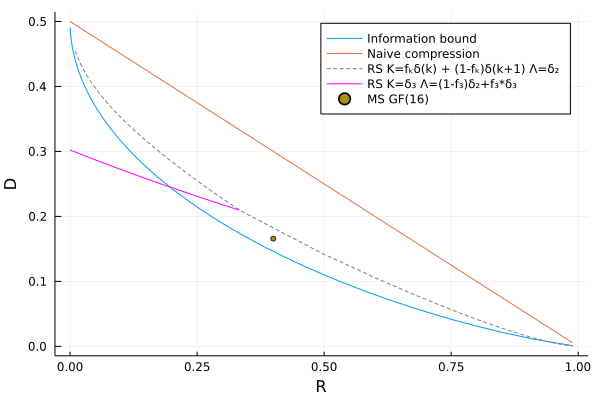

In [188]:
plot_rdb()
scatter!([R], [d], label="MS GF($Q)", ms=3)

## BP

In [205]:
Q = 4
n = 300
R = 0.5
rng = MersenneTwister(1)
A = cycle_code(Q, n, R, rng=rng)
s = rand(1:Q, n)
H = 10;

In [224]:
include("../code/bp_full_gfq.jl")

update_var_ms_quick! (generic function with 1 method)

In [225]:
maxiter = 10^4
rein = 1e-4
parities=fill(NaN, maxiter)
dist=fill(NaN,maxiter)
bp = bp_full_gfq(A, Q, s, H);
gfmult, gfdiv = gftables(Val(Q));

In [226]:
bp_slow = deepcopy(bp)
iteration!(bp_slow, maxiter=maxiter, rein=rein)

(0.9999995480660054, 10000)

In [227]:
performance(bp_slow, s)

(3, 0.13333333333333333)

In [228]:
bp_quick = deepcopy(bp)
iteration_bp_quick!(bp_quick, maxiter=maxiter, rein=rein)

(0.9999982152078356, 10000)

In [229]:
performance(bp_quick, s)

(3, 0.13333333333333333)

In [204]:
iteration_saveall!(bp, damp=0.9, maxiter=maxiter, rein=rein, parities=parities, dist=dist, s=s, tol=1e-14)

(9.547918011776346e-15, 3615)

In [16]:
x = argmax.(bp.belief)
parity(bp, x)

9

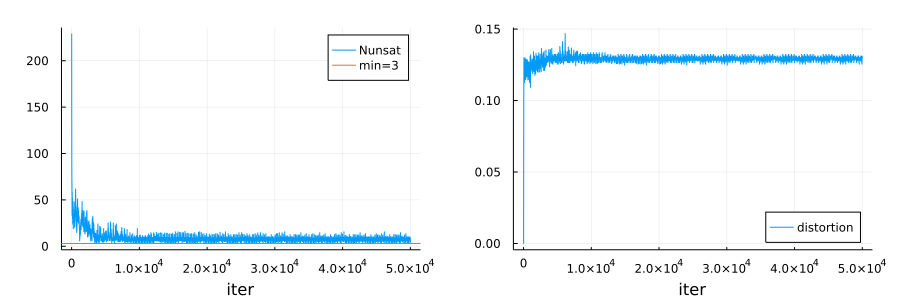

In [17]:
p1 = plot(parities, xlabel="iter", label="Nunsat")
minp = minimum(parities)
hline!(p1, [minp], label="min=$(Int(minp))")
p2 = plot(dist, xlabel="iter", label="distortion", legend=:bottomright)
plot(p1,p2, size=(900,300), margin=5Plots.mm)

In [550]:
nunsat,dist = performance(bp,s)

(3, 0.13333333333333333)

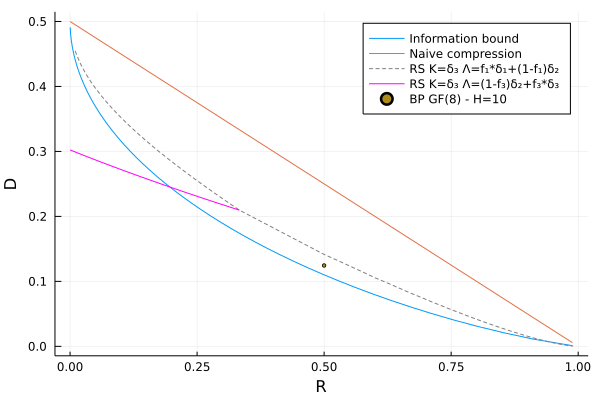

In [551]:
plot_rdb()
scatter!([R], [d], label="BP GF($Q) - H=$H", ms=2)

## Varying the rate

In [100]:
Rs = 0.2:0.1:0.8
navg = 5
d = [fill(NaN,navg) for r in Rs]
maxiter = 10^4
rein = 1/maxiter
damp = 0.0
maxtrials = 10
Q = 32
n = 300;

In [101]:
@showprogress for (i,R) in pairs(Rs)
    for j in 1:navg
        converged = false
        for t in 1:maxtrials
            A = cycle_code(Q, n, R)
            s = rand(1:Q, n)
            ms = ms_full_gfq(A, Q, s)
            ε, iters = iteration_ms!(ms, damp=damp, maxiter=maxiter, rein=rein)
            x = argmax.(ms.belief)
            p = parity(ms, x)
            if p == 0
                d[i][j] = distortion(x, s, Q)
                converged = true
                println("R=$R, avg $j, converged at trial $t")
                break
            end
        end
    end
end

R=0.2, avg 1, converged at trial 1
R=0.2, avg 2, converged at trial 1
R=0.2, avg 4, converged at trial 5


Progress:  14%|█████▉                                   |  ETA: 1:01:47

R=0.2, avg 5, converged at trial 7
R=0.3, avg 1, converged at trial 9
R=0.3, avg 3, converged at trial 2
R=0.3, avg 4, converged at trial 6


Progress:  29%|███████████▊                             |  ETA: 1:11:32

R=0.4, avg 2, converged at trial 1
R=0.4, avg 3, converged at trial 7


Progress:  43%|█████████████████▋                       |  ETA: 1:09:25

R=0.5, avg 1, converged at trial 3
R=0.5, avg 2, converged at trial 4


Progress:  57%|███████████████████████▍                 |  ETA: 1:00:19

R=0.6, avg 3, converged at trial 4


Progress:  71%|█████████████████████████████▎           |  ETA: 0:46:13

R=0.6, avg 5, converged at trial 1
R=0.7, avg 2, converged at trial 4
R=0.7, avg 3, converged at trial 5
R=0.7, avg 4, converged at trial 2


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:26:03

R=0.7, avg 5, converged at trial 8
R=0.8, avg 1, converged at trial 2
R=0.8, avg 3, converged at trial 1
R=0.8, avg 4, converged at trial 4


Progress: 100%|█████████████████████████████████████████| Time: 3:34:33


R=0.8, avg 5, converged at trial 10


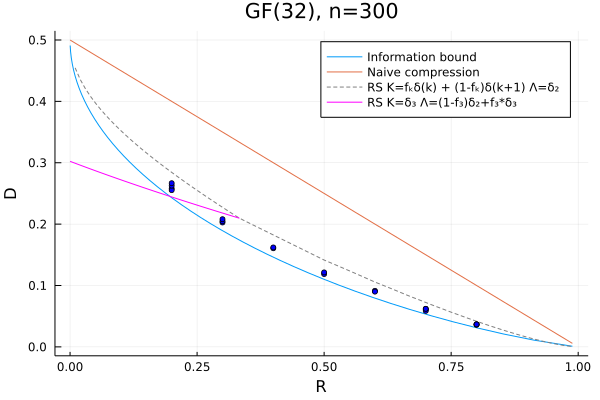

In [102]:
pl = plot_rdb()
for (i,R) in pairs(Rs)
    idx = .!isnan.(d[i])
    scatter!(pl, R*ones(navg)[idx], d[i][idx], label="", ms=3, c=:blue)
end
title!(pl, "GF($Q), n=$n")
pl

In [38]:
Rs = 0.2:0.1:0.8
navg = 5
d2 = [fill(NaN,navg) for r in Rs]
maxiter = 10^4
rein = 1/maxiter
damp = 0.0
maxtrials = 10
Q = 2
n = 1200;

In [39]:
@showprogress for (i,R) in pairs(Rs)
    for j in 1:navg
        converged = false
        for t in 1:maxtrials
            A = cycle_code(Q, n, R)
            s = rand(1:Q, n)
            ms = ms_full_gfq(A, Q, s)
            ε, iters = iteration_ms!(ms, damp=damp, maxiter=maxiter, rein=rein)
            x = argmax.(ms.belief)
            p = parity(ms, x)
            if p == 0
                d2[i][j] = distortion(x, s, Q)
                converged = true
                println("R=$R, avg $j, converged at trial $t")
                break
            end
        end
    end
end

R=0.2, avg 1, converged at trial 1
R=0.2, avg 2, converged at trial 2
R=0.2, avg 3, converged at trial 5
R=0.2, avg 4, converged at trial 3


Progress:  14%|█████▉                                   |  ETA: 0:02:36

R=0.2, avg 5, converged at trial 4
R=0.3, avg 1, converged at trial 2
R=0.3, avg 2, converged at trial 10


Progress:  29%|███████████▊                             |  ETA: 0:03:52

R=0.3, avg 5, converged at trial 5
R=0.4, avg 1, converged at trial 7
R=0.4, avg 2, converged at trial 7
R=0.4, avg 3, converged at trial 1
R=0.4, avg 4, converged at trial 7


Progress:  43%|█████████████████▋                       |  ETA: 0:03:30

R=0.5, avg 1, converged at trial 3
R=0.5, avg 2, converged at trial 2
R=0.5, avg 3, converged at trial 2


Progress:  57%|███████████████████████▍                 |  ETA: 0:02:45

R=0.6, avg 4, converged at trial 2


Progress:  71%|█████████████████████████████▎           |  ETA: 0:02:06

R=0.6, avg 5, converged at trial 1


Progress: 100%|█████████████████████████████████████████| Time: 0:13:16


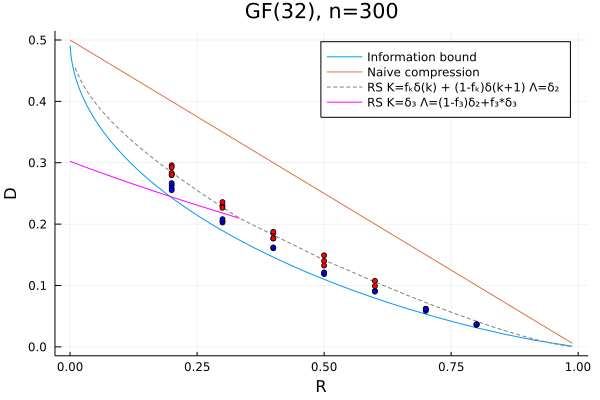

In [104]:
# pl = plot_rdb()
for (i,R) in pairs(Rs)
    idx = .!isnan.(d2[i])
    scatter!(pl, R*ones(navg)[idx], d2[i][idx], label="", ms=3, c=:red)
end
# title!(pl, "GF(2), n=$n")
pl